<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap08/8_1_MNIST_1D_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 8.1: MNIST_1D_Performance**

This notebook runs a simple neural network on the MNIST1D dataset as in figure 8.2a. It uses code from https://github.com/greydanus/mnist1d to generate the data.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [16]:
# Run this if you're in a Colab to install MNIST 1D repository
# %pip install git+https://github.com/greydanus/mnist1d

# Extras for vscode users
# %pip install torch

In [34]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

Let's generate a training and test dataset using the MNIST1D code.  The dataset gets saved as a .pkl file so it doesn't have to be regenerated each time.

In [35]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Successfully loaded data from ./mnist1d_data.pkl
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [41]:
D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions
# TODO✅
# Define a model with two hidden layers of size 100
# And ReLU activations between them
# Replace this line (see Figure 7.8 of book for help):
model = torch.nn.Sequential(
  torch.nn.Linear(D_i, D_k),
  torch.nn.ReLU(),
  torch.nn.Linear(D_k, D_k),
  torch.nn.ReLU(),
  torch.nn.Linear(D_k, D_o)
  )


def weights_init(layer_in):
  # TODO✅:
  # Initialize the parameters with He initialization
  # Replace this line (see figure 7.8 of book for help)
  print("Initializing layer")
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_normal_(layer_in.weight)  # He initialization
    layer_in.bias.data.fill_(0.0)             # Fill input layers with 0

# Call the function you just defined
model.apply(weights_init)


Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer


Sequential(
  (0): Linear(in_features=40, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=10, bias=True)
)

In [42]:
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('int64'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('int64'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Epoch     0, train loss 1.620240, train error 65.68,  test loss 1.717801, test error 70.00
Epoch     1, train loss 1.316530, train error 48.12,  test loss 1.472744, test error 57.70
Epoch     2, train loss 1.126328, train error 40.70,  test loss 1.337012, test error 52.70
Epoch     3, train loss 0.986114, train error 34.20,  test loss 1.260561, test error 48.70
Epoch     4, train loss 0.886889, train error 31.38,  test loss 1.199105, test error 47.00
Epoch     5, train loss 0.782017, train error 27.03,  test loss 1.162162, test error 45.30
Epoch     6, train loss 0.697079, train error 24.12,  test loss 1.133998, test error 44.50
Epoch     7, train loss 0.636319, train error 21.70,  test loss 1.155346, test error 42.70
Epoch     8, train loss 0.558772, train error 18.72,  test loss 1.127914, test error 40.60
Epoch     9, train loss 0.467465, train error 14.53,  test loss 1.1

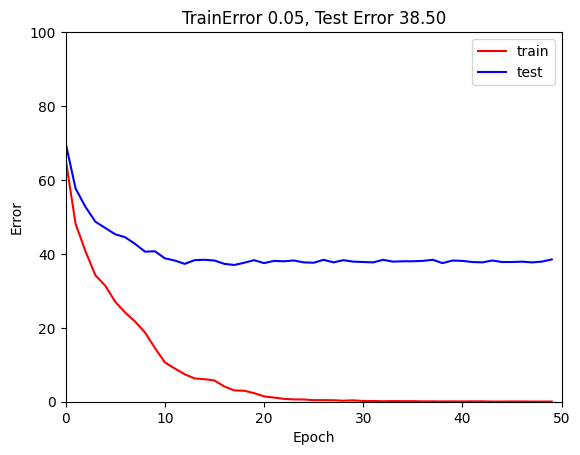

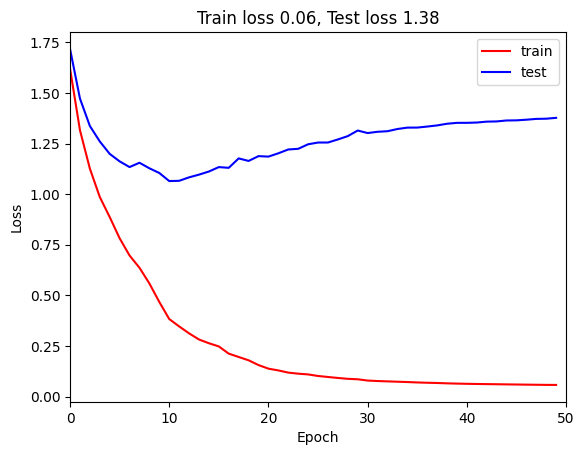

In [43]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()

**TO DO**

Play with the model -- try changing the number of layers, hidden units, learning rate, batch size, momentum or anything else you like.  See if you can improve the test results.

Is it a good idea to optimize the hyperparameters in this way?  Will the final result be a good estimate of the true test performance?

In [82]:
# GENERAL MODEL TESTING FUNCTION

def weights_init_test(layer_in):
  # TODO✅:
  # Initialize the parameters with He initialization
  # Replace this line (see figure 7.8 of book for help)
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_normal_(layer_in.weight)  # He initialization
    layer_in.bias.data.fill_(0.0)             # Fill input layers with 0


def run_test_model(
        name = "",
        D_i = 40,
        D_k = 100,
        D_o = 10,
        num_layers_hidden = 2, 
        n_epoch = 50, 
        learning_rate = 0.05, 
        momentum = 0.9,
        batch_size = 100
        ):

    modules = []

    if num_layers_hidden == 0:
        modules.append(torch.nn.Linear(D_i, D_o))
    else:
        modules.append(torch.nn.Linear(D_i, D_k))
        modules.append(torch.nn.ReLU())
        for i in range(num_layers_hidden-1):
            modules.append(torch.nn.Linear(D_k, D_k))
            modules.append(torch.nn.ReLU())
        modules.append(torch.nn.Linear(D_k, D_o))
    
    nmodel = torch.nn.Sequential(*modules)
    print("Initializing Layers ...")
    nmodel.apply(weights_init_test) # just using He initialization

    # choose cross entropy loss function (equation 5.24)
    loss_function = torch.nn.CrossEntropyLoss()
    # construct SGD optimizer and initialize learning rate and momentum
    optimizer = torch.optim.SGD(nmodel.parameters(), lr = learning_rate, momentum = momentum)
    # object that decreases learning rate by half every 10 epochs
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    x_train = torch.tensor(data['x'].astype('float32'))
    y_train = torch.tensor(data['y'].transpose().astype('int64'))
    x_test= torch.tensor(data['x_test'].astype('float32'))
    y_test = torch.tensor(data['y_test'].astype('int64'))

    # load the data into a class that creates the batches
    data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size = batch_size, shuffle=True, worker_init_fn=np.random.seed(1))

    # Initialize model weights
    print("Initializing Model Weights ...")
    nmodel.apply(weights_init_test)

    # loop over the dataset n_epoch times
    # n_epoch = 50 # initialized in function
    # store the loss and the % correct at each epoch
    losses_train = np.zeros((n_epoch))
    errors_train = np.zeros((n_epoch))
    losses_test = np.zeros((n_epoch))
    errors_test = np.zeros((n_epoch))

    for epoch in range(n_epoch):
        # loop over batches
        for i, batch in enumerate(data_loader):
            # retrieve inputs and labels for this batch
            x_batch, y_batch = batch
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward pass -- calculate model output
            pred = nmodel(x_batch)
            # compute the loss
            loss = loss_function(pred, y_batch)
            # backward pass
            loss.backward()
            # SGD update
            optimizer.step()

        # Run whole dataset to get statistics -- normally wouldn't do this
        pred_train = nmodel(x_train)
        pred_test = nmodel(x_test)
        _, predicted_train_class = torch.max(pred_train.data, 1)
        _, predicted_test_class = torch.max(pred_test.data, 1)
        errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
        errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
        losses_train[epoch] = loss_function(pred_train, y_train).item()
        losses_test[epoch]= loss_function(pred_test, y_test).item()
        if epoch % 5 == 0:
            # doing this to save line display
            print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

        # tell scheduler to consider updating learning rate
        scheduler.step()

    return errors_train, errors_test, losses_train, losses_test, n_epoch, name

def plot_all_test_models(all_tests = []):

    fig, ax = plt.subplots()
    max_epoch = 0

    color_ids = [
        'r','g',
        'b','c',
        'm','y']
    color_index = 0

    plot_ids = [
        '*','-',
        '+','--',
        'x','.',
    ]
    plot_index = 0
    
    for (e_train, e_test, l_train, l_test, epoch, name) in all_tests:
        ax.plot(e_train, color_ids[color_index] + plot_ids[plot_index*2], label=f'train ({name})')
        ax.plot(e_test, color_ids[color_index] + plot_ids[plot_index*2+1], label=f'test ({name})')
        color_index += 1
        if color_index >= len(color_ids):
            color_index = 0
            plot_index += 1
            if plot_index >= len(plot_ids):
                plot_index = 0
        if epoch > max_epoch:
            max_epoch = epoch

    ax.set_ylim(0,100); ax.set_xlim(0,max_epoch)
    ax.set_xlabel('Epoch'); ax.set_ylabel('Error')

    ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
    ax.legend()
    plt.show()

    color_index = 0
    plot_index = 0

    fig, ax = plt.subplots()

    for (e_train, e_test, l_train, l_test, epoch, name) in all_tests:
        ax.plot(l_train, color_ids[color_index] + plot_ids[plot_index*2], label=f'train ({name})')
        ax.plot(l_test, color_ids[color_index] + plot_ids[plot_index*2+1], label=f'test ({name})')
        color_index += 1
        if color_index > len(color_ids):
            color_index = 0
            plot_index += 1
            if plot_index >= len(plot_ids):
                plot_index = 0
    
    ax.set_xlim(0,max_epoch)
    ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
    ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
    ax.legend()
    plt.show()



Initializing Layers ...
Initializing Model Weights ...
Epoch     0, train loss 1.629881, train error 64.35,  test loss 1.684799, test error 67.60
Epoch     5, train loss 1.014641, train error 35.62,  test loss 1.206716, test error 46.70
Epoch    10, train loss 0.799072, train error 27.22,  test loss 1.105397, test error 43.50
Epoch    15, train loss 0.721292, train error 24.38,  test loss 1.103240, test error 43.10
Epoch    20, train loss 0.656311, train error 21.05,  test loss 1.082951, test error 43.10
Epoch    25, train loss 0.630650, train error 20.47,  test loss 1.095612, test error 42.30
Epoch    30, train loss 0.603449, train error 19.65,  test loss 1.106091, test error 43.00
Epoch    35, train loss 0.590826, train error 19.20,  test loss 1.107825, test error 43.10
Epoch    40, train loss 0.579823, train error 18.75,  test loss 1.111093, test error 43.20
Epoch    45, train loss 0.574422, train error 18.53,  test loss 1.117549, test error 43.00
Initializing Layers ...
Initializin

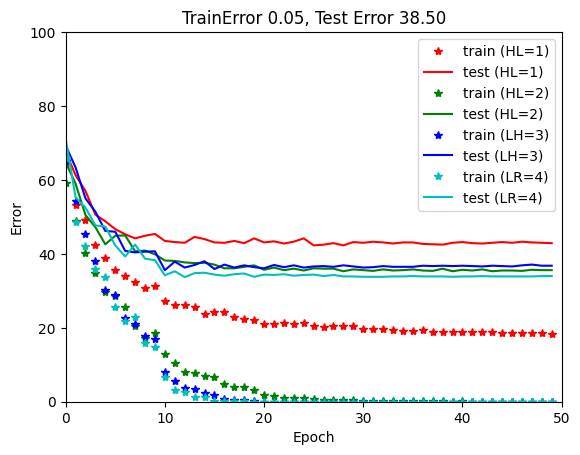

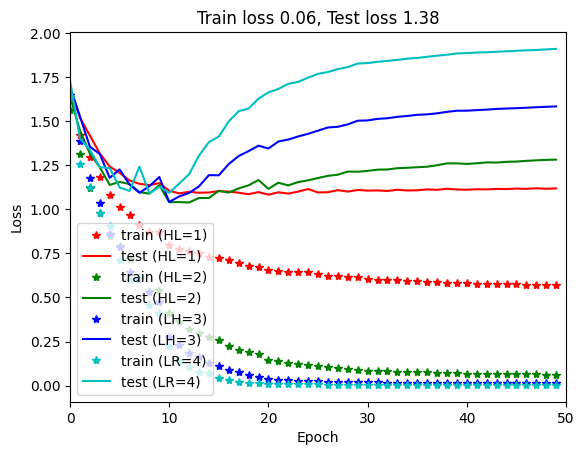

In [85]:
# Testing hidden layers

all_tests = [
    run_test_model("HL=1", num_layers_hidden=1),
    run_test_model("HL=2", num_layers_hidden=2),
    run_test_model("HL=3", num_layers_hidden=3),
    run_test_model("HL=4", num_layers_hidden=4)
]

# These results seem to show that the number of hidden layers
# improves upon the training data, but test data has a greater loss,
# possibly due to overfitting?

plot_all_test_models(all_tests = all_tests)

Initializing Layers ...
Initializing Model Weights ...
Epoch     0, train loss 1.708875, train error 67.60,  test loss 1.783986, test error 73.50
Epoch     5, train loss 1.132887, train error 39.70,  test loss 1.394770, test error 53.80
Epoch    10, train loss 0.803479, train error 26.75,  test loss 1.185250, test error 47.10
Epoch    15, train loss 0.689314, train error 22.78,  test loss 1.175671, test error 46.50
Epoch    20, train loss 0.581942, train error 17.88,  test loss 1.132892, test error 42.70
Epoch    25, train loss 0.532899, train error 16.00,  test loss 1.128664, test error 42.60
Epoch    30, train loss 0.487017, train error 13.68,  test loss 1.130005, test error 42.30
Epoch    35, train loss 0.464209, train error 12.47,  test loss 1.130933, test error 41.50
Epoch    40, train loss 0.445018, train error 11.53,  test loss 1.135085, test error 40.70
Epoch    45, train loss 0.434494, train error 11.20,  test loss 1.135012, test error 41.20
Initializing Layers ...
Initializin

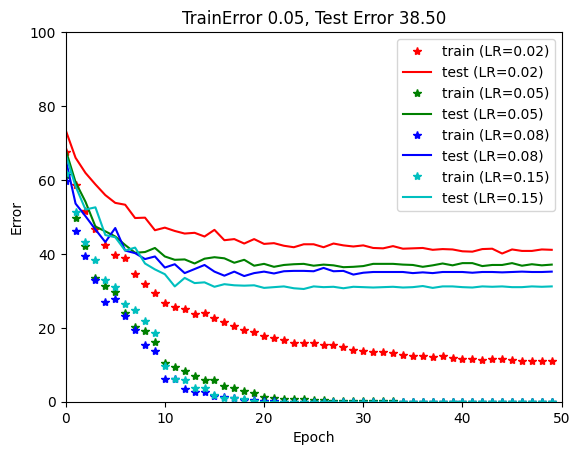

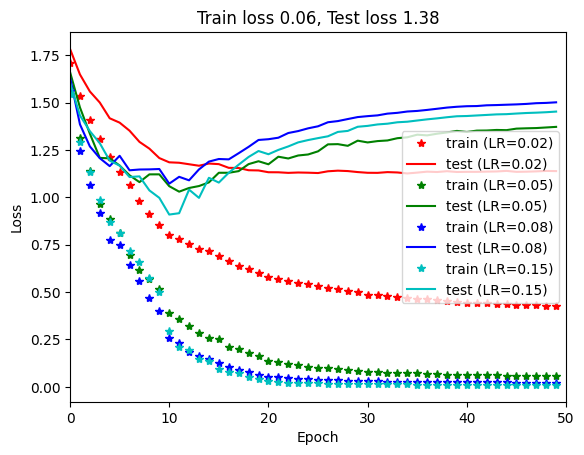

In [86]:
# TESTING THE LEARNING RATE

all_tests = [
    run_test_model("LR=0.02", learning_rate=0.02),
    run_test_model("LR=0.05", learning_rate=0.05),
    run_test_model("LR=0.08", learning_rate=0.08),
    run_test_model("LR=0.15", learning_rate=0.15)
]

# Overfitting also seems to be hurt from this change...
# Lower learning rate showed better results at the cost of higher error.

plot_all_test_models(all_tests=all_tests)

Initializing Layers ...
Initializing Model Weights ...
Epoch     0, train loss 1.905784, train error 72.75,  test loss 1.960400, test error 76.70
Epoch     5, train loss 1.500720, train error 56.50,  test loss 1.603872, test error 65.10
Epoch    10, train loss 1.316085, train error 46.92,  test loss 1.464011, test error 58.60
Epoch    15, train loss 1.240817, train error 44.47,  test loss 1.408997, test error 56.60
Epoch    20, train loss 1.176535, train error 40.95,  test loss 1.365241, test error 54.30
Epoch    25, train loss 1.144133, train error 39.78,  test loss 1.344130, test error 54.00
Epoch    30, train loss 1.117290, train error 38.58,  test loss 1.327098, test error 53.20
Epoch    35, train loss 1.102945, train error 38.10,  test loss 1.318610, test error 52.80
Epoch    40, train loss 1.090104, train error 37.60,  test loss 1.311241, test error 52.70
Epoch    45, train loss 1.083161, train error 37.47,  test loss 1.307159, test error 52.50
Initializing Layers ...
Initializin

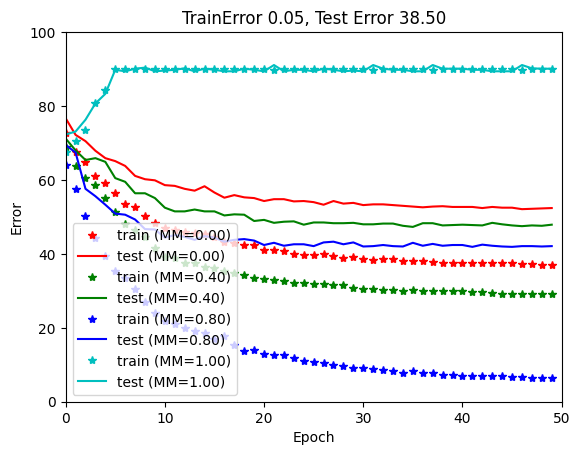

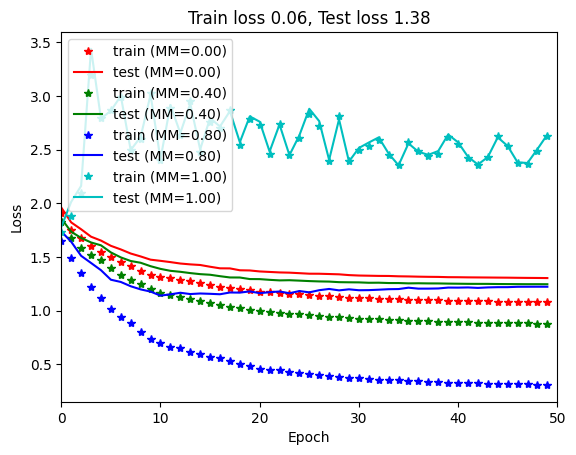

In [87]:
# TESTING THE MOMENTUM

all_tests = [
    run_test_model("MM=0.00", momentum=0.0),
    run_test_model("MM=0.40", momentum=0.4),
    run_test_model("MM=0.80", momentum=0.8),
    run_test_model("MM=1.00", momentum=1.0),
]

# No momentum leads nowhere, too much momentum leads nowhere.
# It seems that a balanced momentum is necessary (shocking!).

plot_all_test_models(all_tests=all_tests)

In [ ]:
# TESTING THE MOMENTUM

all_tests = [
    run_test_model("BS=25", batch_size=25),
    run_test_model("BS=50", batch_size=50),
    run_test_model("BS=100", batch_size=100),
    run_test_model("BS=200", batch_size=200),
]

# No momentum leads nowhere, too much momentum leads nowhere.
# It seems that a balanced momentum is necessary.

plot_all_test_models(all_tests=all_tests)